In [1]:
import sys
sys.path.insert(0, "../")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from ctgan.synthesizers.ctgan import CTGANSynthesizer
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import shuffle

from src.data_loader import load_seer_cutract_dataset
from src.utils import *
from src.ood_predictors import *

/home/nabeel/miniconda3/envs/3s_final_env/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load datasets

In [2]:
from src.data_loader import load_seer_cutract_dataset

seed = 0
seed_everything(seed)

# Load SEER - Source
X_seer, y_seer = load_seer_cutract_dataset(name="seer")
D_seer = X_seer
D_seer["y"] = y_seer
X_train = D_seer

# Load CUTRACT - Target
X_cutract, y_cutract = load_seer_cutract_dataset(name="cutract")
D_cutract = X_cutract
D_cutract["y"] = y_cutract
X_test = D_cutract

X_train = X_train.drop(columns=["grade"])
X_test = X_test.drop(columns=["grade"])

# Fit CTGAN

In [3]:
discrete_columns = [
    "age",
    "comorbidities",
    "treatment",
    "stage",
]

syn_model = CTGANSynthesizer(
    embedding_dim=128,
    generator_dim=(256, 256),
    discriminator_dim=(256, 256),
    generator_lr=2e-4,
    generator_decay=1e-6,
    discriminator_lr=2e-4,
    discriminator_decay=1e-6,
    batch_size=500,
    discriminator_steps=1,
    log_frequency=True,
    verbose=False,
    epochs=300,
    pac=10,
    cuda=True,
)
syn_model.set_random_state(seed)
syn_model.fit(train_data=X_train, discrete_columns=discrete_columns)


# Helpers

In [4]:
def get_scores(data, trained_model_dict):
    from tqdm import tqdm

    target_acc = {}

    for model in tqdm(model_dict.keys()):
        print(model)
        clf = trained_model_dict[model]
        y_score = clf.predict_proba(data.drop("y", axis=1))[:, 1]
        y_pred = clf.predict(data.drop("y", axis=1))

        target_acc[model] = accuracy_score(data["y"], y_pred)
  
    return target_acc 


# Sample synthetic data

In [5]:
n_samples = 100000
X_syn, _ = syn_model.sample(n_samples, shift=False)

X_syn.psa = X_syn.psa.astype(int)
X_syn


,age,psa,comorbidities,treatment,stage,y
0,73,96,2,3,4,0
1,58,97,0,4,4,1
2,64,8,0,3,2,0
3,55,3,0,3,2,0
4,73,17,0,1,2,0
...,...,...,...,...,...,...
99995,68,5,0,3,2,1
99996,52,8,0,1,3,0
99997,51,4,0,3,2,0
99998,65,14,0,3,3,1


# Train base models & compute performance scores

In [6]:
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

model_dict = {
    "mlp": MLPClassifier(random_state=seed),
    "knn": KNeighborsClassifier(),
    "dt": DecisionTreeClassifier(random_state=seed),
    "rf": RandomForestClassifier(random_state=seed),
    "gbc": GradientBoostingClassifier(random_state=seed),
    "bag": BaggingClassifier(random_state=seed),
    "ada": AdaBoostClassifier(random_state=seed),
    "lr": LogisticRegression(random_state=seed),
}


# Train models on source data
trained_model_dict = train_models(X_train, model_dict)

X_train, X_val = train_test_split(X_train, test_size=0.2, random_state=seed)

# Evaluate on train, val, test, and synthetic data
test_scores = get_scores(data=X_test, trained_model_dict=trained_model_dict)

val_scores = get_scores(data=X_val, trained_model_dict=trained_model_dict)

base_syn_scores = get_scores(data=X_syn, trained_model_dict=trained_model_dict)


 25%|██▌       | 2/8 [00:00<00:00, 13.21it/s]

mlp
knn
dt
rf


100%|██████████| 8/8 [00:00<00:00, 31.84it/s]


gbc
bag
ada
lr


 38%|███▊      | 3/8 [00:00<00:00, 29.54it/s]

mlp
knn
dt
rf


100%|██████████| 8/8 [00:00<00:00, 29.50it/s]


gbc
bag
ada
lr


 12%|█▎        | 1/8 [00:00<00:00,  9.76it/s]

mlp
knn


 25%|██▌       | 2/8 [00:01<00:06,  1.15s/it]

dt
rf


 50%|█████     | 4/8 [00:03<00:04,  1.04s/it]

gbc


 75%|███████▌  | 6/8 [00:04<00:01,  1.65it/s]

bag
ada


100%|██████████| 8/8 [00:04<00:00,  1.61it/s]

lr


# Define marginals from test set that we will sample from

In [7]:
# age_conditionals = X_test.age.to_numpy()
age_conditionals = np.random.normal(
    loc=X_test.age.mean(), scale=X_test.age.std() / 2, size=len(X_test.age.to_numpy())
)
psa_conditionals = X_test.psa.to_numpy()  #
# psa_conditionals = np.random.normal(loc=X_test.psa.mean(), scale=X_test.psa.std(), size=10000)
treatment_conditionals = X_test.stage.to_numpy()
stage_conditionals = X_test.treatment.to_numpy()
comorbidities_conditionals = X_test.comorbidities.to_numpy()

indices = np.array(list(range(len(age_conditionals))))


# Test access to different number of features (prior knowledge) - SYNTHETIC

In [8]:
scores = {}

# sequentially add features of prior knowledge
for n_feat in [1, 2, 3, 4, 5]:

    synth, _ = syn_model.sample(1, shift=False)

    for i in range(1000):
        condidx = int(np.random.choice(indices, 1)[0])
        age_val = int(age_conditionals[condidx])
        psa_val = psa_conditionals[condidx]
        treatment_val = treatment_conditionals[condidx]
        stage_val = stage_conditionals[condidx]
        comorbidities_val = comorbidities_conditionals[condidx]

        if n_feat == 0:
            syn_data = X_syn.sample(100)
            synth = pd.concat([synth, syn_data])

        if n_feat == 1:
            idx = np.where((X_syn["age"] == age_val))[0]
            if len(idx) > 0:
                syn_data = X_syn.iloc[idx]
                synth = pd.concat([synth, syn_data])

        if n_feat == 2:
            idx = np.where((X_syn["age"] == age_val) & (X_syn["psa"] == psa_val))[0]
            if len(idx) > 0:
                syn_data = X_syn.iloc[idx]
                synth = pd.concat([synth, syn_data])

        if n_feat == 3:
            idx = np.where(
                (X_syn["age"] == age_val)
                & (X_syn["psa"] == psa_val)
                & (X_syn["treatment"] == treatment_val)
            )[0]
            if len(idx) > 0:
                syn_data = X_syn.iloc[idx]
                synth = pd.concat([synth, syn_data])

        if n_feat == 4:
            idx = np.where(
                (X_syn["age"] == age_val)
                & (X_syn["psa"] == psa_val)
                & (X_syn["treatment"] == treatment_val)
                & (X_syn["stage"] == stage_val)
            )[0]
            if len(idx) > 0:
                syn_data = X_syn.iloc[idx]
                synth = pd.concat([synth, syn_data])

        if n_feat == 5:
            idx = np.where(
                (X_syn["age"] == age_val)
                & (X_syn["psa"] == psa_val)
                & (
                    X_syn["treatment"]
                    == treatment_val
                    & (X_syn["stage"] == stage_val)
                    & (X_syn["comorbidities"] == comorbidities_val)
                )
            )[0]
            if len(idx) > 0:
                syn_data = X_syn.iloc[idx]
                synth = pd.concat([synth, syn_data])

    features = ["age", "psa", "comorbidities", "treatment", "stage", "y"]
    X_syn_sampled = synth[features]

    # Compute scores
    score = get_scores(data=X_syn_sampled, trained_model_dict=trained_model_dict)
    scores[n_feat] = score


  0%|          | 0/8 [00:00<?, ?it/s]

mlp


 12%|█▎        | 1/8 [00:02<00:15,  2.26s/it]

knn


 25%|██▌       | 2/8 [00:58<03:24, 34.05s/it]

dt


 38%|███▊      | 3/8 [00:59<01:34, 18.90s/it]

rf


 50%|█████     | 4/8 [01:51<02:08, 32.11s/it]

gbc


 62%|██████▎   | 5/8 [01:56<01:07, 22.37s/it]

bag


 75%|███████▌  | 6/8 [02:02<00:33, 16.78s/it]

ada


 88%|████████▊ | 7/8 [02:28<00:19, 19.85s/it]

lr


 12%|█▎        | 1/8 [00:00<00:00,  9.73it/s]

mlp
knn


 25%|██▌       | 2/8 [00:01<00:06,  1.07s/it]

dt
rf


 62%|██████▎   | 5/8 [00:03<00:01,  1.72it/s]

gbc
bag


 75%|███████▌  | 6/8 [00:03<00:00,  2.09it/s]

ada


100%|██████████| 8/8 [00:04<00:00,  1.98it/s]


lr


  0%|          | 0/8 [00:00<?, ?it/s]

mlp
knn


 25%|██▌       | 2/8 [00:00<00:01,  4.64it/s]

dt
rf


 88%|████████▊ | 7/8 [00:00<00:00,  8.70it/s]

gbc
bag
ada
lr


 25%|██▌       | 2/8 [00:00<00:00, 15.20it/s]

mlp
knn
dt
rf


100%|██████████| 8/8 [00:00<00:00, 27.78it/s]


gbc
bag
ada
lr


100%|██████████| 8/8 [00:00<00:00, 90.84it/s]

mlp
knn
dt
rf
gbc
bag
ada
lr


# Test access to different number of features (prior knowledge) - SLICES OF X_train

In [9]:
train_scores = {}

X_slice = X_train

# sequentially add features of prior knowledge
for n_feat in [1, 2, 3, 4, 5]:

    train_slice = X_slice.sample(1)

    for i in range(1000):
        condidx = int(np.random.choice(indices, 1)[0])
        age_val = int(age_conditionals[condidx])
        psa_val = psa_conditionals[condidx]
        treatment_val = treatment_conditionals[condidx]
        stage_val = stage_conditionals[condidx]
        comorbidities_val = comorbidities_conditionals[condidx]

        if n_feat == 0:
            x_data = X_train.sample(100)
            train_slice = pd.concat([train_slice, x_data])

        if n_feat == 1:
            idx = np.where((X_slice["age"] == age_val))[0]
            if len(idx) > 0:
                x_data = X_slice.iloc[idx]
                train_slice = pd.concat([train_slice, x_data])

        if n_feat == 2:
            idx = np.where((X_slice["age"] == age_val) & (X_slice["psa"] == psa_val))[0]
            if len(idx) > 0:
                x_data = X_slice.iloc[idx]
                train_slice = pd.concat([train_slice, x_data])

        if n_feat == 3:
            idx = np.where(
                (X_slice["age"] == age_val)
                & (X_slice["psa"] == psa_val)
                & (X_slice["treatment"] == treatment_val)
            )[0]
            if len(idx) > 0:
                x_data = X_slice.iloc[idx]
                train_slice = pd.concat([train_slice, x_data])

        if n_feat == 4:
            idx = np.where(
                (X_slice["age"] == age_val)
                & (X_slice["psa"] == psa_val)
                & (
                    X_slice["treatment"]
                    == treatment_val & (X_slice["comorbidities"] == comorbidities_val)
                )
            )[0]
         
            if len(idx) > 0:
                x_data = X_slice.iloc[idx]
                train_slice = pd.concat([train_slice, x_data])

        if n_feat == 5:
            idx = np.where(
                (X_slice["age"] == age_val)
                & (X_slice["psa"] == psa_val)
                & (
                    X_slice["treatment"]
                    == treatment_val
                    & (X_train["stage"] == stage_val)
                    & (X_slice["comorbidities"] == comorbidities_val)
                )
            )[0]
            if len(idx) > 0:
                x_data = X_slice.iloc[idx]
                train_slice = pd.concat([train_slice, syn_data])

    features = ["age", "psa", "comorbidities", "treatment", "stage", "y"]
    X_train_sampled = train_slice[features]

    train_score = get_scores(
        data=X_train_sampled, trained_model_dict=trained_model_dict
    )
    train_scores[n_feat] = train_score


  0%|          | 0/8 [00:00<?, ?it/s]

mlp


 12%|█▎        | 1/8 [00:00<00:02,  2.44it/s]

knn


 38%|███▊      | 3/8 [00:08<00:13,  2.62s/it]

dt
rf


 50%|█████     | 4/8 [00:15<00:18,  4.57s/it]

gbc


 62%|██████▎   | 5/8 [00:16<00:09,  3.12s/it]

bag


 75%|███████▌  | 6/8 [00:17<00:04,  2.33s/it]

ada


100%|██████████| 8/8 [00:20<00:00,  2.57s/it]


lr


 25%|██▌       | 2/8 [00:00<00:00, 19.00it/s]

mlp
knn
dt
rf
gbc
bag
ada
lr


100%|██████████| 8/8 [00:00<00:00, 102.49it/s]


mlp
knn
dt
rf
gbc
bag
ada
lr


100%|██████████| 8/8 [00:00<00:00, 241.78it/s]


mlp
knn
dt
rf
gbc
bag
ada
lr


100%|██████████| 8/8 [00:00<00:00, 251.93it/s]

mlp
knn
dt
rf
gbc
bag
ada
lr


# Collate the results

In [10]:
atc_scores = {}
atc_scores_mc = {}
im_est_scores = {}
doc_feat_scores = {}
for model_name in trained_model_dict.keys():
    atc_scores[model_name] = test_atc(model_name, trained_model_dict, X_test, X_val)
    atc_scores_mc[model_name] = test_atc_mc(
        model_name, trained_model_dict, X_test, X_val
    )
    im_est_scores[model_name] = test_im_est(
        model_name, trained_model_dict, X_test, X_val
    )
    doc_feat_scores[model_name] = test_doc_feat(
        model_name, trained_model_dict, X_test, X_val
    )


In [11]:
target = []
source = []
syn = []
train_slice = []
atc = []
atc_mc = []
im_est = []
doc_feat = []

for model_name in trained_model_dict.keys():
    target.append([test_scores[model_name] for i in range(len(scores.keys()))])
    source.append([val_scores[model_name] for i in range(len(scores.keys()))])
    syn.append([scores[i][model_name] for i in scores.keys()])
    train_slice.append([train_scores[i][model_name] for i in train_scores.keys()])
    atc.append([atc_scores[model_name] for i in range(len(scores.keys()))])
    atc_mc.append([atc_scores_mc[model_name] for i in range(len(scores.keys()))])
    im_est.append([im_est_scores[model_name] for i in range(len(scores.keys()))])
    doc_feat.append([doc_feat_scores[model_name] for i in range(len(scores.keys()))])


# Compute the mean and std --- across predictive models

In [12]:
target_mean = np.mean(np.array(target), axis=0)
source_mean = np.mean(np.array(source), axis=0)
syn_mean = np.mean(np.array(syn), axis=0)
slice_mean = np.mean(np.array(train_slice), axis=0)
atc_mean = np.mean(np.array(atc), axis=0)
atc_mc_mean = np.mean(np.array(atc_mc), axis=0)
im_est_mean = np.mean(np.array(im_est), axis=0)

target_std = np.std(np.array(target), axis=0)
source_std = np.std(np.array(source), axis=0)
syn_std = np.std(np.array(syn), axis=0)
slice_std = np.std(np.array(train_slice), axis=0)
atc_std = np.std(np.array(atc), axis=0)
atc_mc_std = np.std(np.array(atc_mc), axis=0)
im_est_std = np.std(np.array(im_est), axis=0)

x = [val + 1 for val in list(range(len(target_mean)))]


# Plot results curve

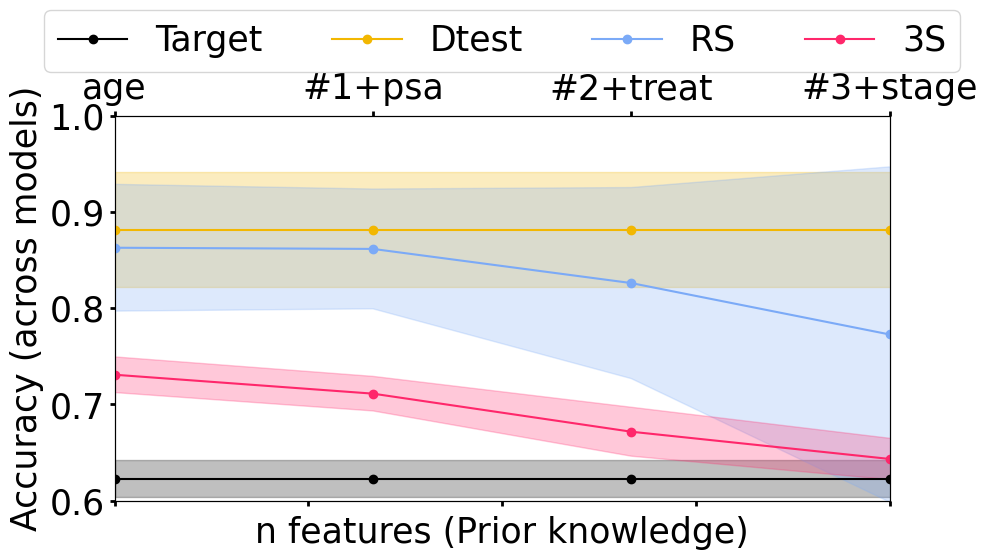

In [14]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.reload_library()
SMALL_SIZE = 40
MEDIUM_SIZE = 50
BIGGER_SIZE = 50

plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=SMALL_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=14)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=14)  # fontsize of the tick labels
plt.rc("ytick", labelsize=14)  # fontsize of the tick labels
plt.rc("legend", fontsize=14)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title

fig, ax1 = plt.subplots(figsize=(10, 5))
ax2 = ax1.twiny()
plt.plot(x, target_mean, color="k", label="Target", marker="o")
plt.fill_between(
    x, target_mean - target_std, target_mean + target_std, alpha=0.25, color="k"
)
plt.plot(x, source_mean, color="#F2B701", label="Dtest", marker="o")
plt.fill_between(
    x, source_mean - source_std, source_mean + source_std, alpha=0.25, color="#F2B701"
)

plt.plot(x, slice_mean, color="#7BAAF7", label="RS", marker="o")
plt.fill_between(
    x, slice_mean - slice_std, slice_mean + slice_std, alpha=0.25, color="#7BAAF7"
)

plt.plot(x, syn_mean, color="#FF276B", label="3S", marker="o")
plt.fill_between(x, syn_mean - syn_std, syn_mean + syn_std, alpha=0.25, color="#FF276B")

ax1.set_xticks(range(len(x)))
ax1.set_xticklabels([])

ax2.set_xticks(range(len(x)))
ax2.set_xticklabels([" ", "age", "#1+psa", "#2+treat", "#3+stage"])

plt.xlim([1, 4])
plt.ylim([0.6, 1])

ax1.set_xlabel("n features (Prior knowledge)", fontsize=25)
ax1.set_ylabel("Accuracy (across models)", fontsize=25)


# Adjust the following values according to your preference
ax1.tick_params(axis="both", which="major", labelsize=25, width=2)
ax2.tick_params(axis="both", which="major", labelsize=25, width=2)

legend = plt.legend(loc="upper center", bbox_to_anchor=(0.5, 1.32), ncol=4, fontsize=25)

plt.show()


# Check the actual predictive performance for the different data "sample types"

In [15]:
target_model_scores = {}
source_model_scores = {}
syn_model_scores = {}
slice_model_scores = {}
atc_model_scores = {}
atc_mc_model_scores = {}
im_est_model_scores = {}
doc_feat_model_scores = {}

for idx, model_name in enumerate(trained_model_dict.keys()):
    target_model_scores[model_name] = target[idx][-2]
    source_model_scores[model_name] = source[idx][-2]
    syn_model_scores[model_name] = syn[idx][-2]
    slice_model_scores[model_name] = train_slice[idx][-2]
    atc_model_scores[model_name] = atc[idx][-2] / 100
    atc_mc_model_scores[model_name] = atc_mc[idx][-2] / 100
    im_est_model_scores[model_name] = im_est[idx][-2] / 100
    doc_feat_model_scores[model_name] = doc_feat[idx][-2] / 100


In [16]:
# SORT THE SCORES TO PUT INTO PANDAS

# 3S
scores_new = sorted(syn_model_scores.items(), key=lambda item: item[1])
ours = [score[0] for score in scores_new]
syn_res = {}
for score in scores_new:
    syn_res[score[0]] = score[1]

# Source
scores_new = sorted(source_model_scores.items(), key=lambda item: item[1])
all = [score[0] for score in scores_new]
all_res = {}
for score in scores_new:
    all_res[score[0]] = score[1]

# Target
scores_new = sorted(target_model_scores.items(), key=lambda item: item[1])
true = [score[0] for score in scores_new]
true_res = {}
for score in scores_new:
    true_res[score[0]] = score[1]

# RS
scores_new = sorted(slice_model_scores.items(), key=lambda item: item[1])
RS = [score[0] for score in scores_new]
RS_res = {}
for score in scores_new:
    RS_res[score[0]] = score[1]

# ATC Model
scores_new = sorted(atc_model_scores.items(), key=lambda item: item[1])
atc_score_list = [score[0] for score in scores_new]
atc_res = {}
for score in scores_new:
    atc_res[score[0]] = score[1]

# ATC MC Model
scores_new = sorted(atc_mc_model_scores.items(), key=lambda item: item[1])
atc_mc_score_list = [score[0] for score in scores_new]
atc_mc_res = {}
for score in scores_new:
    atc_mc_res[score[0]] = score[1]

# IM_EST Model
scores_new = sorted(im_est_model_scores.items(), key=lambda item: item[1])
im_est_score_list = [score[0] for score in scores_new]
im_est_res = {}
for score in scores_new:
    im_est_res[score[0]] = score[1]

# DOC_FEAT Model
scores_new = sorted(doc_feat_model_scores.items(), key=lambda item: item[1])
doc_feat_score_list = [score[0] for score in scores_new]
doc_feat_res = {}
for score in scores_new:
    doc_feat_res[score[0]] = score[1]


In [17]:
syn_error = {}
all_error = {}
rs_error = {}
atc_error = {}
atc_mc_error = {}
im_est_error = {}
doc_feat_error = {}

# compute absolute error vs true
for model in RS_res.keys():
    syn_error[model] = abs(syn_res[model] - true_res[model])
    all_error[model] = abs(all_res[model] - true_res[model])
    rs_error[model] = abs(RS_res[model] - true_res[model])
    atc_error[model] = abs(atc_res[model] - true_res[model])
    atc_mc_error[model] = abs(atc_mc_res[model] - true_res[model])
    im_est_error[model] = abs(im_est_res[model] - true_res[model])
    doc_feat_error[model] = abs(doc_feat_res[model] - true_res[model])

# add means to each dict
syn_error["mean"] = np.mean(list(syn_error.values()))
all_error["mean"] = np.mean(list(all_error.values()))
rs_error["mean"] = np.mean(list(rs_error.values()))
atc_error["mean"] = np.mean(list(atc_error.values()))
atc_mc_error["mean"] = np.mean(list(atc_mc_error.values()))
im_est_error["mean"] = np.mean(list(im_est_error.values()))
doc_feat_error["mean"] = np.mean(list(doc_feat_error.values()))

# add all dicts to a list
error_list = [
    syn_error,
    all_error,
    rs_error,
    atc_error,
    atc_mc_error,
    im_est_error,
    doc_feat_error,
]

# create a dataframe from the list
df = pd.DataFrame(
    error_list,
    index=[
        "3S-Testing",
        "All (Source)",
        "RS (Source)",
        "ATC",
        "ATC_MC",
        "IM_EST",
        "DOC_FEAT",
    ],
)
df


,lr,ada,gbc,mlp,knn,bag,dt,rf,mean
3S-Testing,0.029848,0.051222,0.029994,0.000282,0.020221,0.011998,0.029137,0.015061,0.023470
All (Source),0.210500,0.208000,0.207500,0.170000,0.233250,0.327000,0.364750,0.346250,0.258406
RS (Source),0.094506,0.027597,0.026838,0.014825,0.213656,0.298578,0.392513,0.373513,0.180253
ATC,0.166000,0.253500,0.162500,0.140000,0.369500,0.288000,0.405500,0.214500,0.249938
ATC_MC,0.166000,0.253500,0.162500,0.140000,0.369500,0.288000,0.405500,0.214500,0.249938
IM_EST,0.160811,0.207286,0.156525,0.126529,0.131088,0.278616,0.392418,0.268561,0.215229
DOC_FEAT,0.161238,0.208539,0.160512,0.116515,0.148400,0.211278,0.383736,0.223679,0.201737
